In [1]:
import copy
import pywt
import scipy.stats
import scipy.signal
import scipy.io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from kpnet.handler import *
from kpnet.network import *
from kpnet.signal import *
from kpnet.callback import *
from kpnet.entropy import *
from kpnet.patterns import *
from kpnet.utils import *

from wavelets import *

In [2]:
N = 64
time_interval = 2 ** 16

In [3]:
time_interval

65536

In [4]:
np.random.seed(0)
neuron = 5
# 20, 0.078
# Period - N, 3, alpha=0.044, beta=0.2, gamma=3.2
net = KPNetworkTanh(N, alpha=0.05, beta=0.3, gamma=2.2)

callbacks = {}
for i in range(N):
    callbacks['W_' + str(i)] = Weight0Callback(time_interval, neuron, i)
callbacks['L2'] = NormL2Callback(time_interval)
callbacks['L1'] = NormL1Callback(time_interval)
callbacks['N5'] = NeuronActivityCallback(time_interval, neuron)
callbacks['N3'] = NeuronActivityCallback(time_interval, 3)
callbacks['N11'] = NeuronActivityCallback(time_interval, 11)
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(N), ZeroSignal(N)])
handler = ComputationHandler(time_interval)
%time results = handler.run(net, signal, callbacks)

CPU times: user 9.41 s, sys: 12 ms, total: 9.42 s
Wall time: 9.43 s


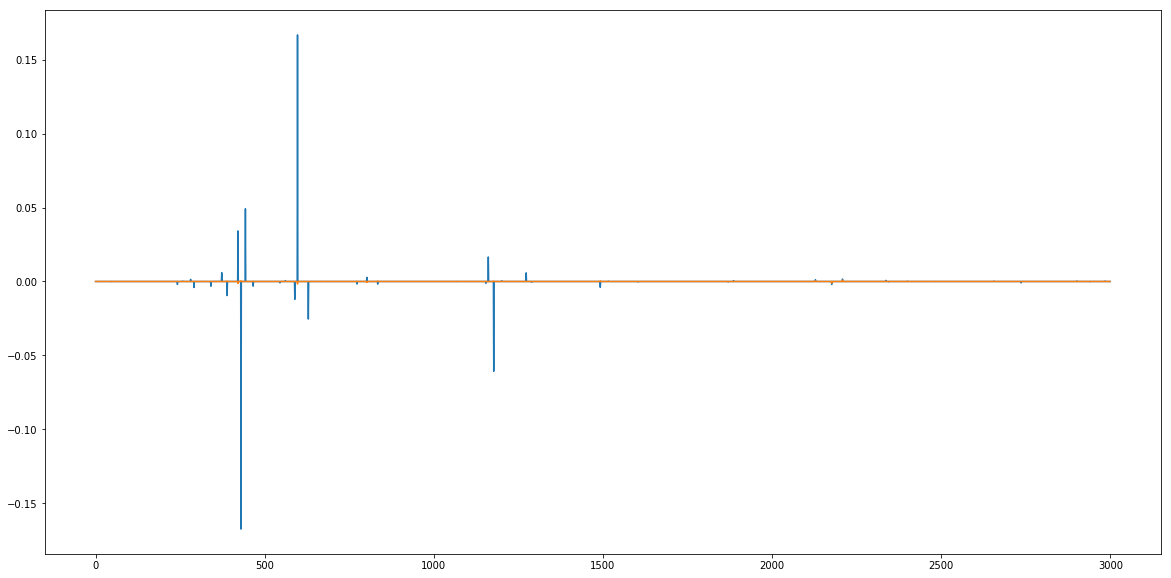

In [5]:
plt.figure(figsize=(20, 10))
plt.plot((results['N3'] - results['N5'])[6000:9000])
plt.plot((results['N5']  - results['N11'])[6000:9000])
plt.show()

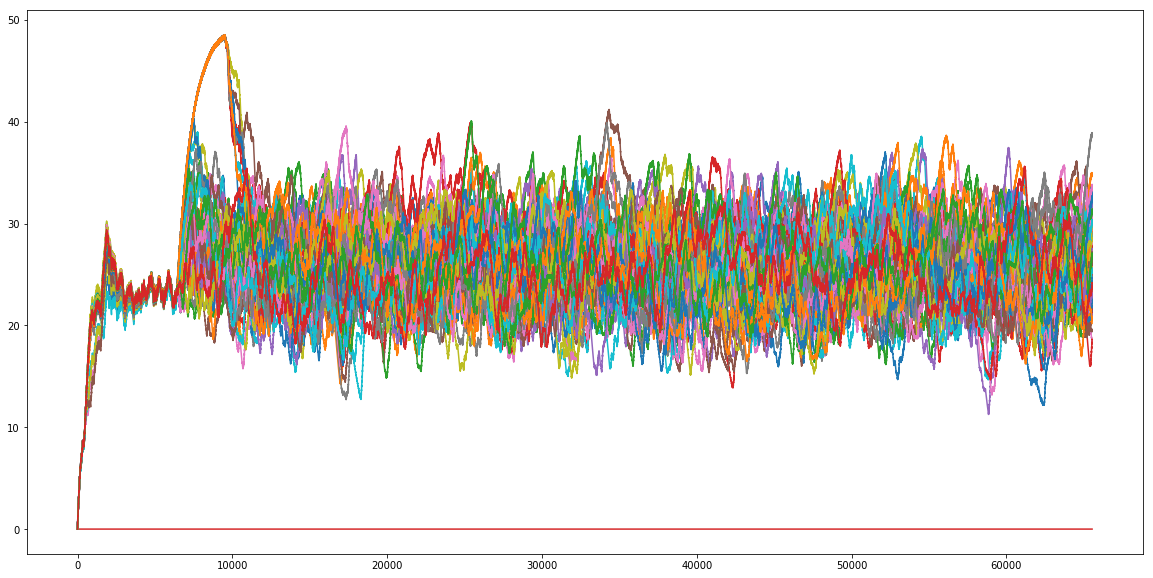

In [6]:
plt.figure(figsize=(20, 10))
for key, value in results.items():
    if 'W_' in key:
        plt.plot(value)
plt.show()

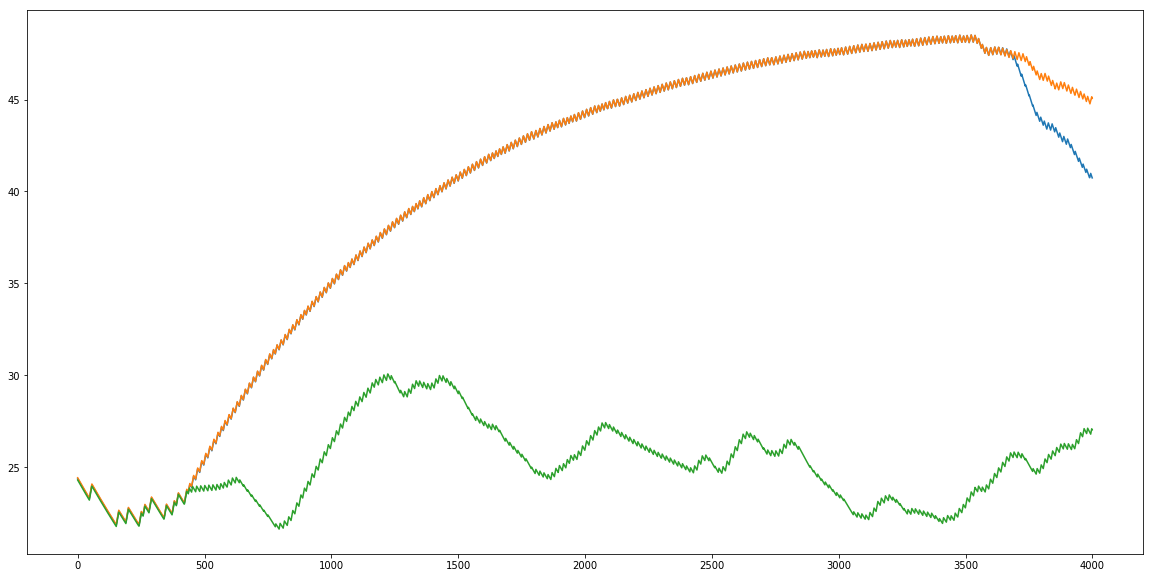

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(results['W_3'][6000:10000] )
plt.plot(results['W_11'][6000:10000])
plt.plot(results['W_15'][6000:10000])
plt.show()

In [8]:
signal1 = results['W_3']
signal2 = results['W_11']
signal3 = results['W_15']

In [9]:
def power(signal):
    wa = WaveletTransform(signal, wavelet=Ricker(), mask_coi=True)
    return wa.wavelet_power

In [10]:
def mask_coi_power(signal):
    wa = WaveletTransform(signal, wavelet=Ricker(), mask_coi=True)
    coi = wa.wavelet.coi
    s = wa.scales
    t = wa.time
    T, S = np.meshgrid(t, s)
    inside_coi = (coi(S) < T) & (T < (T.max() - coi(S)))
    masked_power = np.ma.masked_where(~inside_coi, wa.wavelet_power)
    masked_power.set_fill_value(0)
    return #masked_power.filled()

In [11]:
def swt_p(signal, begin, end, wavelet = 'db2'):
    level = pywt.swt_max_level(signal.shape[0])
    print(level)
    swt = pywt.swt(signal, wavelet, level=level)
    power = np.flip(np.asarray([np.sum(dB[begin:end] ** 2) for dA, dB in swt]), axis=0)
    return power / np.sum(power)

In [12]:
begin = 6000
end   = 10000

16
16
16


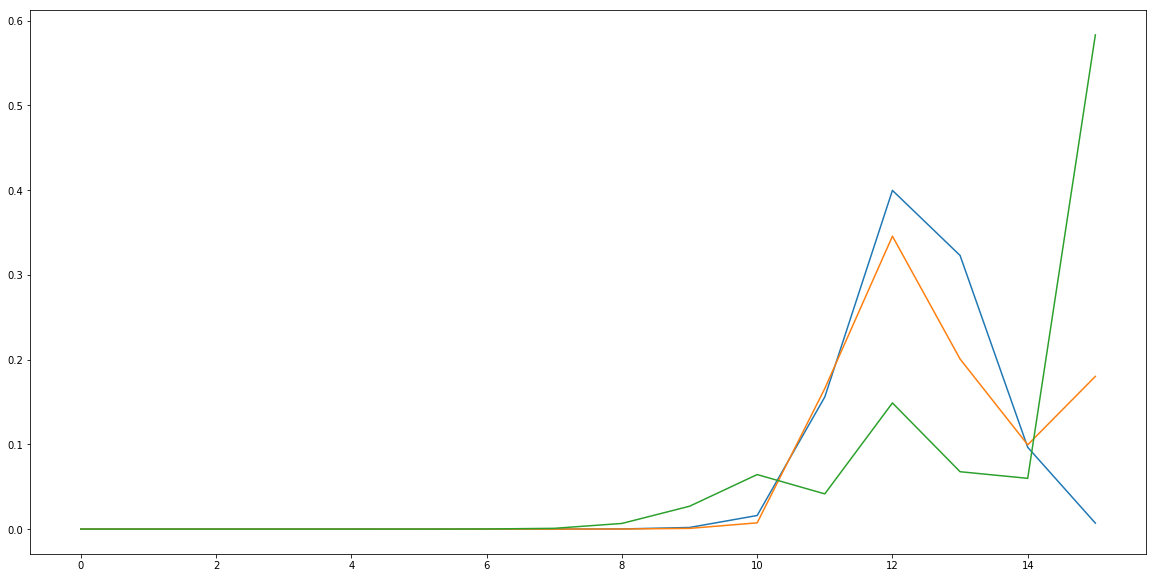

Entropy: 0.190332910012


In [13]:
swt_p1 = swt_p(signal1, begin, end, 'db4')
swt_p2 = swt_p(signal2, begin, end, 'db4')
swt_p3 = swt_p(signal3, begin, end, 'db4')
plt.figure(figsize=(20, 10))
plt.plot(swt_p1)
plt.plot(swt_p2)
plt.plot(swt_p3)
plt.show()
print("Entropy: " + str(scipy.stats.entropy(swt_p1, swt_p2)))

In [14]:
print("Entropy: " + str(scipy.stats.entropy(swt_p1, swt_p3)))

Entropy: 1.09216187055


In [47]:
scipy.stats.ks_2samp([begin:end], signal2[begin:end])

Ks_2sampResult(statistic=0.060749999999999971, pvalue=7.1566052906250008e-07)

In [15]:
scipy.io.savemat('good_sample.mat', results)

In [ ]:
power1 = power(results['W_5_14'])
power2 = power(results['W_5_22'])

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(results['W_5_14'][begin:end])
plt.plot(results['W_5_22'][begin:end])
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(results['W_5_14'][begin:end]-results['W_5_22'][begin:end])
plt.show()

In [ ]:
p1 = np.sum(power1[:, begin:end], axis=1) / np.sum(power1[:, begin:end])
p2 = np.sum(power2[:, begin:end], axis=1) / np.sum(power2[:, begin:end])
plt.figure(figsize=(20, 10))
plt.plot(p1)
plt.plot(p2)
plt.show()

In [ ]:
plt.plot(np.cumsum(p1))
plt.plot(np.cumsum(p2))
plt.show()

In [ ]:
cwt = WaveletAnalysis(results['W'][5, 14][5000:], wavelet=Ricker(), mask_coi=True)
plt.figure(figsize=(20, 10))
ax = plt.subplot()
cwt.plot_power(ax)
plt.show()

In [ ]:
level = pywt.swt_max_level(results['W'][5, 1].shape[0])
dec = pywt.swt(results['W'][5, 22], 'db2', level=level)

In [ ]:
level = pywt.swt_max_level(time_interval)
dec1 = pywt.swt(results['W'][5, 14], 'db3', level=level)
dec2 = pywt.swt(results['W'][5, 22], 'db3', level=level)
dec3 = pywt.swt(results['W'][5, 15], 'db3', level=level)
dec4 = pywt.swt(results['W'][5, 13], 'db3', level=level)
dec5 = pywt.swt(results['W'][5, 9], 'db3', level=level)
p1 = [np.sum(dec1[i][1][16000:21000] ** 2) for i in range(level)]
p1 /= np.sum(p1)
p2 = [np.sum(dec2[i][1][16000:21000] ** 2) for i in range(level)]
p2 /= np.sum(p2)
p3 = [np.sum(dec3[i][1][16000:21000] ** 2) for i in range(level)]
p3 /= np.sum(p3)
p4 = [np.sum(dec4[i][1][16000:21000] ** 2) for i in range(level)]
p4 /= np.sum(p4)
p5 = [np.sum(dec5[i][1][16000:21000] ** 2) for i in range(level)]
p5 /= np.sum(p5)
plt.figure(figsize=(20, 10))
plt.plot(p1, label='14')
plt.plot(p3, label='15')
plt.plot(p2, label='22')
plt.plot(p4, label='13')
plt.plot(p5, label='9')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(dec1[5][1])
plt.show()

In [ ]:
np.sum(dec1[2][1] ** 2)

In [ ]:
packet = pywt.WaveletPacket(results['W'][5, 14], 'db2')

In [ ]:
def collect_coeff(l):
    


packet.walk()

In [ ]:
x

In [ ]:
plt.plot(x)
plt.show()

In [ ]:
p

In [ ]:
cwt = WaveletAnalysis(det[0][3000:], wavelet=Ricker())
plt.figure(figsize=(20, 10)) 
ax = plt.subplot()
cwt.plot_power(ax)
plt.show()

In [ ]:
def neuron_cluster(neuron, weights, threshold=0.01):
    neurons = weights.shape[1]
    cwts = [EntropyCWT(weights[neuron, j, :], Ricker()) for j in range(neurons)]
    entropies = np.zeros(shape=(neurons, neurons))
    for j in range(neurons):
        for k in range(neurons):
            entropies[j][k] = EntropyCWT.compare(cwts[j], cwts[k], 
                              EntropyCWT.distribution, EntropyCWT.jensen)
    c = 1
    cs = np.zeros(shape=(neurons, ))
    ents = np.inf + np.zeros(shape=(neurons, ))
    for j in range(neurons):
        if cs[j] == 0:
            found = 0
            for k in range(neurons):
                if entropies[j][k] <= np.min([ents[k], threshold]) and j != k:
                    cs[k] = c
                    ents[k] = entropies[j][k]
                if entropies[j][k] <= np.min([ents[j], threshold]) and j != k:
                    cs[j] = c
                    ents[j] = entropies[j][k]
            c += 1
            
    return cs

In [ ]:
def parse_clusters(encoded_clusters, neuron, min_size=1):
    clusters = []
    for num in np.unique(encoded_clusters):
        if num != 0:
            cluster = set()
            for j in range(N):
                if encoded_clusters[j] == num:
                    cluster.add(j)
            if len(cluster) > min_size:
                cluster.add(neuron)
                clusters.append(cluster)
            
    return clusters

In [ ]:
clusters = []
for i in range(N):
    cluster = parse_clusters(neuron_cluster(i, results['W'][:, :, 18000:21000], 0.01), i, 5)
    if len(cluster) > 0:
        clusters.append(cluster)

In [ ]:
def find_max_intersect(cluster, clusters, collected):
    max_len = 0
    n = -1
    c = -1
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            if not collected[i][j]:
                res = cluster & clusters[i][j]
                if len(res) > max_len:
                    max_len = len(res)
                    n = i
                    c = j
    return n, c

In [ ]:
collected = []
for i in range(len(clusters)):
    collected.append([False] * len(clusters[i]))
    
cores = []
subs = []
for i in range(len(clusters)):
    for j in range(len(clusters[i])):
        if not collected[i][j]:
            cores.append(copy.deepcopy(clusters[i][j]))
            subs.append(copy.deepcopy(clusters[i][j]))
            collected[i][j] = True
            n, c = find_max_intersect(cores[-1], clusters, collected)
            while n != -1 and c != -1:
                collected[n][c] = True
                cores[-1] &= clusters[n][c]
                subs[-1] |= clusters[n][c]
                n, c = find_max_intersect(cores[-1], clusters, collected)

In [ ]:
cores

In [ ]:
def in_cluster(n, clusters):
    for i, cs in enumerate(res):
        if len(cs) > 1:
            for j in cs:
                if j == n:
                    return i
    return -1
                    
values = [0.5] * N
c = 0.6
for n in cores[-2]:
    values[n] = c

for n in (subs[-2] - cores[-2]):
    values[n] = c + 0.2
         
g = nx.complete_graph(N)        
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos,
                       node_color = values, node_size = 500)
nx.draw_networkx_labels(g, pos, {i: str(i) for i in range(N)})
black_edges = [(b, e) for b, e in g.edges() if (b in cores[-2]) and (e in cores[-2])]
grey_edges = [(b, e) for b, e in g.edges() if (b in subs[-2]) and (e in subs[-2])]
white_edges = [edge for edge in g.edges() if edge not in black_edges]
nx.draw_networkx_edges(g, pos, edgelist=white_edges, edge_color='lightgray')
nx.draw_networkx_edges(g, pos, edgelist=grey_edges, edge_color='gray')
nx.draw_networkx_edges(g, pos, edgelist=black_edges)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
scipy.io.savemat('W.mat', results)